# NYT API

In [23]:
from __future__ import division
import pandas
from matplotlib import pyplot as plt 
import seaborn as sns
import requests
import json
import math
import time
import csv
from textblob import TextBlob

%matplotlib inline

In [20]:
def grab_data(keyword):

    # set key
    key = "be8992a420bfd16cf65e8757f77a5403:8:44644296"

    # set base url
    base_url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"

    # set search parameters
    search_params = {"q": keyword,
                     "api-key": key,
                     "begin_date": "20100101",  # date must be in YYYYMMDD format
                     "end_date": "20141231"}

    # make request
    r = requests.get(base_url, params=search_params)

    # wait 3 seconds for the GET request
    time.sleep(3)

    # convert to a dictionary
    data = json.loads(r.text)

    # get number of hits
    hits = data['response']['meta']['hits']
    print("number of hits: ", str(hits))

    # get number of pages
    pages = int(math.ceil(hits / 10))
    print("number of pages: ", str(pages))
    
    data_all = list()
    
    # now we're ready to loop through the pages
    for i in range(pages):
        print("collecting page", str(i))

        # set the page parameter
        search_params['page'] = i

        # make request
        r = requests.get(base_url, params=search_params)

        # get text and convert to a dictionary
        data = json.loads(r.text)
        
        # append dictionary to master list
        data_all.append(data)
        time.sleep(3)  # pause between calls
    filename = '../data/nyt_%s.txt' % keyword
    with open(filename, 'w') as outfile:
        json.dump(data_all, outfile)
    return data_all

In [29]:
def gen_df(data):

    # make an empty dataframe where we'll hold all of our docs for every page
    all_docs = pandas.DataFrame()
    for e in data:
        # get just the docs
        docs = e['response']['docs']
        df_temp = pandas.DataFrame(docs)

        # add those docs to the dataframe
        all_docs = pandas.concat([all_docs, df_temp], ignore_index=True)
    return(all_docs)

In [24]:
def polarity(text):
    tb = TextBlob(text)
    return(tb.sentiment.polarity)

In [25]:
def subjectivity(text):
    tb = TextBlob(text)
    return(tb.sentiment.subjectivity)

In [38]:
def clean_data(df):
    df['year'] = df['pub_date'].str[:4]
    df['polarity'] = df['snippet'].apply(polarity)
    df['subjectivity'] = df['snippet'].apply(subjectivity)
    grouped = df[['year','_id']].groupby('year').count()
    grouped_text = df[['year', 'polarity','subjectivity']].groupby('year').mean()
    grouped_all = grouped.join(grouped_text)
    grouped_all.rename(columns={'_id': 'count'}, inplace=True)
    return grouped_all

In [ ]:
data_gm = grab_data("GM")

In [ ]:
df_gm = gen_df(data_gm)

In [39]:
grouped_gm = clean_data(df_gm)
grouped_gm

,count,polarity,subjectivity
year,,,
2010,88,0.065364,0.387856
2011,43,0.004315,0.256413
2012,68,0.078652,0.317951
2013,44,0.072676,0.235900
2014,94,0.076784,0.394213


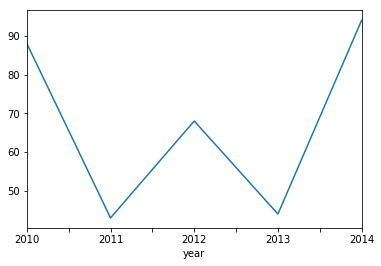

In [40]:
grouped_gm['count'].plot(kind='line')

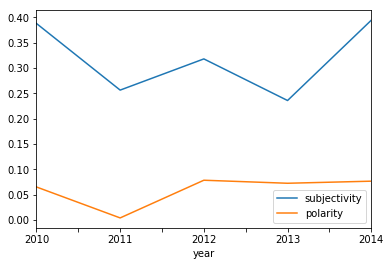

In [41]:
grouped_gm[['subjectivity', 'polarity']].plot(kind='line')

In [42]:
grouped_gm.corr()

,count,polarity,subjectivity
count,1.000000,0.545958,0.991607
polarity,0.545958,1.000000,0.443319
subjectivity,0.991607,0.443319,1.000000


In [ ]:
data_tesla = grab_data("Tesla")

In [ ]:
df_tesla = gen_df(data_tesla)

In [46]:
grouped_tesla = clean_data(df_tesla)
grouped_tesla

,count,polarity,subjectivity
year,,,
2010,237,0.078909,0.295477
2011,132,0.083324,0.294749
2012,174,0.109621,0.325692
2013,210,0.084143,0.323414
2014,241,0.080411,0.306244


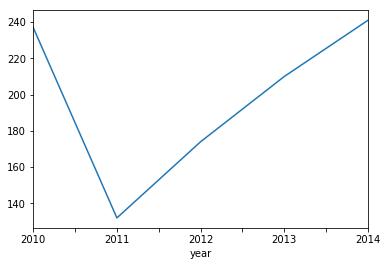

In [48]:
grouped_tesla['count'].plot(kind='line')

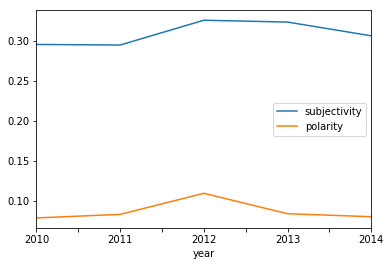

In [49]:
grouped_tesla[['subjectivity', 'polarity']].plot(kind='line')

In [50]:
grouped_tesla.corr()

,count,polarity,subjectivity
count,1.000000,-0.401469,0.024404
polarity,-0.401469,1.000000,0.686891
subjectivity,0.024404,0.686891,1.000000
